In [1]:
import tensorflow as tf
import numpy as np
import h5py

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback

%matplotlib inline
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
# Hyperparameter, veränderbar
enc_dim_4 = 800
enc_dim_3 = 400
enc_dim_2 = 130
enc_dim_1 = 60
h_dim = 4
dec_dim_1 = 70
dec_dim_2 = 120
dec_dim_3 = 200
dec_dim_4 = 450

activation = 'tanh'
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
rv = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
epochs = 60
batch_size = 5
l1 = 0
l2 = 1e-4

In [3]:
train_size = 900 # 1000 Daten stehen zur Verfügung
test_size = 100
label_size = 6*6
elements = 192 # FEM-Model hat 192 Elemente
image_size = 6*elements # = 1152

In [4]:
# Vorbereitung der Daten
train_images = np.zeros((1, image_size))
train_labels = np.zeros((1, label_size))
test_images = train_images
test_labels = train_labels

with h5py.File("./AE_Inputs_Modell_2.hdf5", 'r') as f:   # Import Daten
    for i in range(0, train_size):
        data = f["Sample{}".format(i)][()].reshape(1, image_size)
        train_images = np.r_[train_images, data]
    for i in range(train_size, test_size+train_size):
        data = f["Sample{}".format(i)][()].reshape(1, image_size)
        test_images = np.r_[test_images, data]

with h5py.File("./AE_labels_Modell_2.hdf5", 'r') as f:   # Import Labels
    for i in range(0, train_size):
        data = f["Label3_{}".format(i)][()].reshape(1, label_size)
        train_labels = np.r_[train_labels, data]
    for i in range(train_size, test_size+train_size):
        data = f["Label3_{}".format(i)][()].reshape(1, label_size)
        test_labels = np.r_[test_labels, data]

# Daten werden nach physikalischer Größe sortiert mit dem jeweiligen Mittel und Varianz
# aus dem Trainingsset normalisiert
train_images = np.delete(train_images, 0, 0)
stressMean = np.mean(train_images[:,0:384]) # 384=2*192, Werte einer Größe stehen hintereinander
stressDev = np.std(train_images[:,0:384])
pressMean = np.mean(train_images[:,384:768])
pressDev = np.std(train_images[:,384:768])
fluxMean = np.mean(train_images[:,768:])
fluxDev = np.std(train_images[:,768:])

test_images = np.delete(test_images, 0, 0)

# Normalisieren:
def prep_x (x):
    stress = (x[:,0:384].astype('float32') - stressMean) / stressDev
    press = (x[:,384:768].astype('float32') - pressMean) / pressDev
    flux = (x[:,768:].astype('float32') - fluxMean) / fluxDev
    return np.c_[stress, press, flux]

def prep_y (y,):  # Label wird lediglich durch 180 geteilt zum "Normalisieren"
    y = np.delete(y, 0, 0)
    return y.astype('float32') / 180

train_i = prep_x(train_images)
test_i = prep_x(test_images)
train_l = prep_y(train_labels)
test_l = prep_y(test_labels)

In [5]:
# Autoencoder Klasse mit eigenen Handels für En- und Decoder
class Autoencoder(keras.Model):
    def __init__(self, name='autoencoder'):
        super(Autoencoder, self).__init__(name=name)
        self.encoder = tf.keras.Sequential(
            [
                layers.InputLayer(image_size+label_size),
                layers.Dense(enc_dim_4, activation=activation, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)),
                layers.Dense(enc_dim_3, activation=activation, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)),
                layers.Dense(enc_dim_2, activation=activation, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)),
                layers.Dense(enc_dim_1, activation=activation, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)),
                layers.Dense(h_dim*2, activation=activation, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)),
            ],
            name = 'encoder'
        )

        self.decoder = tf.keras.Sequential(
            [
                layers.InputLayer(h_dim+label_size),
                layers.Dense(dec_dim_1, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)),
                layers.Dense(dec_dim_2, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)),
                layers.Dense(dec_dim_3, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)),
                layers.Dense(dec_dim_4, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)),
                layers.Dense(image_size, activation='tanh', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1, l2=l2)),
            ],
            name = 'decoder'
        )

    def encode(self, x):  # Kompletter Vorgang aus Encoderdefinition aus der Arbeit (mit Sample etc.)
        inputs = layers.concatenate(x)
        mean, logvar = tf.split(self.encoder(inputs), num_or_size_splits=2, axis=1)
        epsilon = tf.random.normal(shape=(tf.shape(inputs)[0], h_dim)) # Zufallsvariable Epsilon zum sampeln von h
        h = mean + tf.exp(logvar / 2) * epsilon   # sampeln...
        [_, l] = x
        h_l = layers.concatenate([h, l])
        return mean, logvar, h, h_l

    def decode(self, h_l): # latent Space decoden
        return self.decoder(h_l)

    def call(self, x):
        self.mean, self.logvar, h, h_l = self.encode(x)
        recon = self.decode(h_l)
        return recon

    def KL_loss(self, x_true, x_pred): # Kullback-Leibler-Divergenzverlust, Formel mit logvar
        return (0.5 * K.sum(K.exp(self.logvar) + K.square(self.mean) - 1. - (self.logvar), axis=-1))

    def recon_loss(self, x_true, x_pred):  # Rekonstruktionsverlust, Methode wird bei den Hyperparametern definiert
        return K.sum(rv(x_true, x_pred), axis=-1)

    def vae_loss(self, x_true, x_pred):  # gesamter Verlust
        vae_loss = self.recon_loss(x_true, x_pred) + self.KL_loss(x_true, x_pred)
        return vae_loss

In [7]:
# Callback, eigentlich nur für die Visualisierung der Verluste an jedem Epochenende
class CustomCallback(Callback):
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.KL_losses = []
        self.val_KL_losses = []
        self.recon_losses = []
        self.val_recon_losses = []


    def on_epoch_end(self, epoch, logs={}):
        self.x.append(epoch)
        self.losses.append(logs["loss"])
        self.val_losses.append(logs["val_loss"])
        self.KL_losses.append(logs["KL_loss"])
        self.val_KL_losses.append(logs["val_KL_loss"])
        self.recon_losses.append(logs["recon_loss"])
        self.val_recon_losses.append(logs["val_recon_loss"])

        clear_output(wait=True)

        fig = plt.figure(figsize=(10, 8))

        ax1 = plt.subplot2grid((4,4), (0,0), colspan=2, rowspan=2)
        ax2 = plt.subplot2grid((4,4), (0,2), colspan=2, rowspan=2)
        ax3 = plt.subplot2grid((4,4), (2,1), colspan=2, rowspan=2)

        ax3.plot(self.x, self.losses, lw=4, label="Training")
        ax3.plot(self.x, self.val_losses, lw=4, label="Validierung")
        ax3.legend(fontsize=16)
        ax3.set_xlabel("Epoche", fontsize=16)
        ax3.set_ylabel("Verlust gesamt", fontsize=16)

        ax2.plot(self.x, self.KL_losses, lw=4, label="Training")
        ax2.plot(self.x, self.val_KL_losses, lw=4, label="Validierung")
        ax2.legend(fontsize=16)
        ax2.set_xlabel("Epoche", fontsize=16)
        ax2.set_ylabel("KL Verlust", fontsize=16)

        ax1.plot(self.x, self.recon_losses, lw=4, label="Training")
        ax1.plot(self.x, self.val_recon_losses, lw=4, label="Validierung")
        ax1.legend(fontsize=16)
        ax1.set_xlabel("Epoche", fontsize=16)
        ax1.set_ylabel("Rekonstruktionsverlust", fontsize=16)

        plt.tight_layout()
        plt.show()

custom_callback = CustomCallback()

In [6]:
ae = Autoencoder()

ae.compile(optimizer=optimizer, loss=ae.vae_loss, metrics = [ae.KL_loss, ae.recon_loss])
# Metrics um die Verluste später einzeln verfolgen zu können

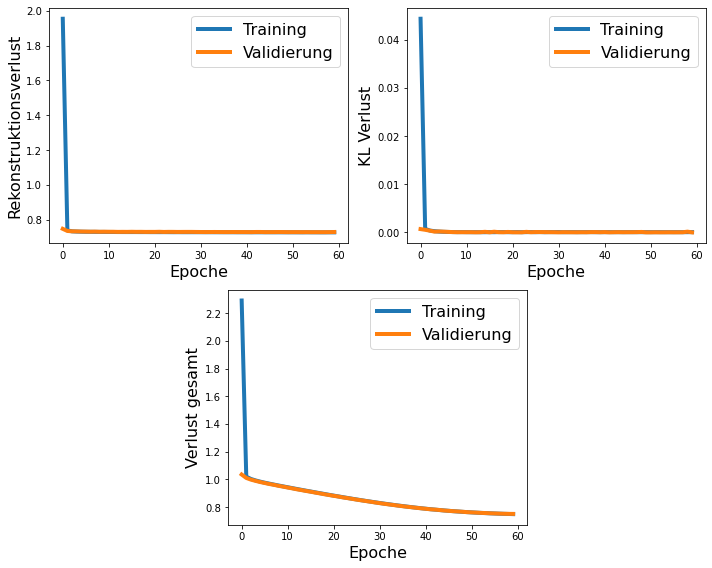

810/810 [==============================] - 3s 3ms/sample - loss: 0.7489 - KL_loss: 5.1443e-05 - recon_loss: 0.7275 - val_loss: 0.7504 - val_KL_loss: 3.0655e-06 - val_recon_loss: 0.7295


In [8]:
ae.fit([train_i, train_l], train_i, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[custom_callback])
# Input: Trainingsdaten und -label, Grundwahrheit: Trainingslabel
# In Hyperparametern bereits festgelegt: Epochenanzahl, Batchgröße
# Validation Split = 0,1 für Trennung Training- und Validierungsdatenset, fix festgelegt in der Arbeit

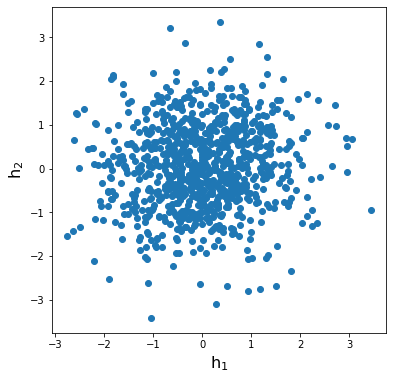

In [9]:
# 2D-Darstellung des latenten Raums, egal welche Dimension er hat immer nur die ersten beiden
[mean, logvar, h, encodings] = ae.encode([train_i, train_l]) # alle Trainingsdaten werden encoded

plt.figure(figsize=(6,6))

plt.scatter(h[:, 0], h[:, 1]) # je erste beiden Werte plotten
plt.xlabel("h$_1$", fontsize=16)
plt.ylabel("h$_2$", fontsize=16)

plt.show()

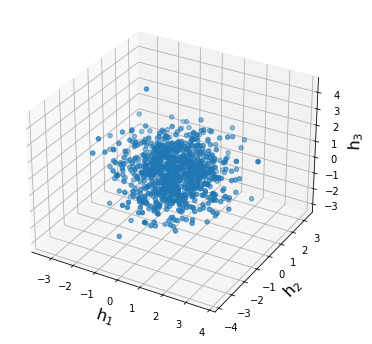

In [10]:
# 3D-Darstellung des latenten Raums, nur erste drei Werte
[mean, logvar, h, encodings] = ae.encode([train_i, train_l])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(h[:, 0], h[:, 1], h[:,2])
ax.set_xlabel("h$_1$", fontsize=16)
ax.set_ylabel("h$_2$", fontsize=16)
ax.set_zlabel("h$_3$", fontsize=16)

plt.show()

[ 60. 180.  90.   0.  30.   0. 150. 120.  30.  90.   0.  60.  30.  60.
 120. 150.  30. 120.  30.  30.  60.  60. 120.  60.   0.   0.   0.   0.
  90.  60.  90. 120. 180. 120.   0. 150.]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



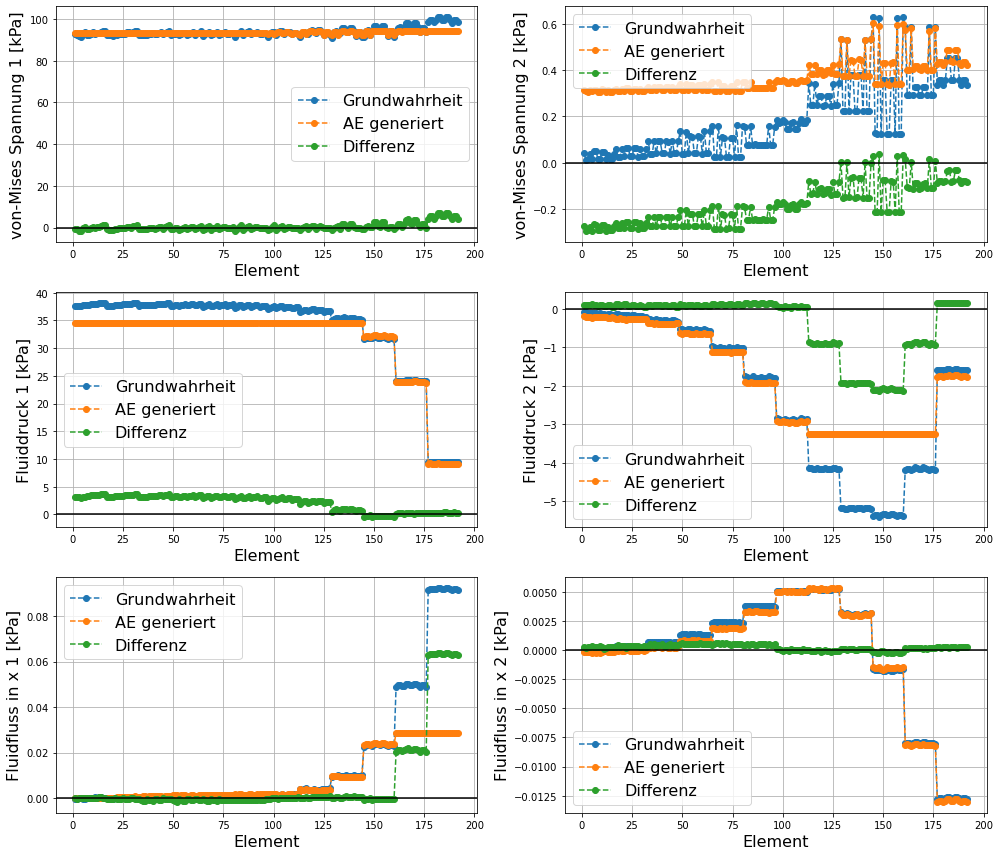

In [11]:
# Darstellung der Testrekonstruktion: originale Simulationsdaten, Rekonstruktion des Decoders und die Differenz
a=2 # konkretes Beispiel aus dem Testdatenset
wunschLabel = test_l[a] # bereits "normalisiertes" Label
print(test_labels[a])   # zeigt Winkelkombi die rekonstruiert wird
h = np.zeros(h_dim)     # KL-Verlust stets so gering, dass 0-Vektor gilt, sonst anpassen!

h_l = np.concatenate([h, wunschLabel])  # Prep latent Space und Label als Eingabe in den Decoder
h_l = h_l.reshape([1, h_dim+label_size])
vec = ae.decode(h_l)  # Rekonstruktion

x_true = test_images[a].reshape([1, image_size])  # Originaldaten, nicht normalisiert

def redo (x): # ent-normalisieren
    stress = x[:,0:384] * stressDev + stressMean
    press = x[:,384:768] * pressDev + pressMean
    flux = x[:,768:] * fluxDev + fluxMean
    return np.c_[stress, press, flux]

vec_true = redo(vec)

diff_true = x_true - vec_true  # Differenz der nicht normalisierten Originaldaten und rekonstruierten Werten

n = []
for i in range(1, elements+1): # Hilfsvektor zur Darstellung der Elemente
    n=np.r_[n, np.array([i])]
n = n.reshape(1, elements)

# Darstellung, mit eigenem Diagramm für jede ausgewertete Größe zu einem Zeitpunkt
fig, axs = plt.subplots(3,2, figsize=(14,12))

axs[0,0].plot(n[0,:192], x_true[0,:192], "--o", label="Grundwahrheit")
axs[0,0].plot(n[0,:192], vec_true[0,:192], "--o", label="AE generiert")
axs[0,0].plot(n[0,:192], diff_true[0,:192], "--o", label="Differenz")
axs[0,0].set_ylabel("von-Mises Spannung 1 [kPa]", fontsize=16)

axs[0,1].plot(n[0,:192], x_true[0,192:384], "--o", label="Grundwahrheit")
axs[0,1].plot(n[0,:192], vec_true[0,192:384], "--o", label="AE generiert")
axs[0,1].plot(n[0,:192], diff_true[0,192:384], "--o", label="Differenz")
axs[0,1].set_ylabel("von-Mises Spannung 2 [kPa]", fontsize=16)

axs[1,0].plot(n[0,:192], x_true[0,384:576], "--o", label="Grundwahrheit")
axs[1,0].plot(n[0,:192], vec_true[0,384:576], "--o", label="AE generiert")
axs[1,0].plot(n[0,:192], diff_true[0,384:576], "--o", label="Differenz")
axs[1,0].set_ylabel("Fluiddruck 1 [kPa]", fontsize=16)

axs[1,1].plot(n[0,:192], x_true[0,576:768], "--o", label="Grundwahrheit")
axs[1,1].plot(n[0,:192], vec_true[0,576:768], "--o", label="AE generiert")
axs[1,1].plot(n[0,:192], diff_true[0,576:768], "--o", label="Differenz")
axs[1,1].set_ylabel("Fluiddruck 2 [kPa]", fontsize=16)

axs[2,0].plot(n[0,:192], x_true[0,768:960], "--o", label="Grundwahrheit")
axs[2,0].plot(n[0,:192], vec_true[0,768:960], "--o", label="AE generiert")
axs[2,0].plot(n[0,:192], diff_true[0,768:960], "--o", label="Differenz")
axs[2,0].set_ylabel("Fluidfluss in x 1 [kPa]", fontsize=16)

axs[2,1].plot(n[0,:192], x_true[0,960:], "--o", label="Grundwahrheit")
axs[2,1].plot(n[0,:192], vec_true[0,960:], "--o", label="AE generiert")
axs[2,1].plot(n[0,:192], diff_true[0,960:], "--o", label="Differenz")
axs[2,1].set_ylabel("Fluidfluss in x 2 [kPa]", fontsize=16)

for (i, j) in zip([0,0,1,1,2,2], [0,1,0,1,0,1]):  # Parameter für alle Diagramme, je nach Wunsch auskommentiert
    axs[i,j].grid()
    axs[i,j].axhline(y=0, color='k')
    axs[i,j].legend(fontsize=16)
    axs[i,j].set_xlabel("Element", fontsize=16)

plt.tight_layout()
plt.show()